In [37]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import mvts_utils as utils
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df = pd.read_csv("/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv")
df.head(5)

,Unnamed: 0,Date,counts,speed
0,0,2020-01-01,394.0,1.1506
1,1,2020-01-02,397.0,1.1504
2,2,2020-01-03,382.0,1.1563
3,3,2020-01-04,395.0,1.1561
4,4,2020-01-05,394.0,1.1540


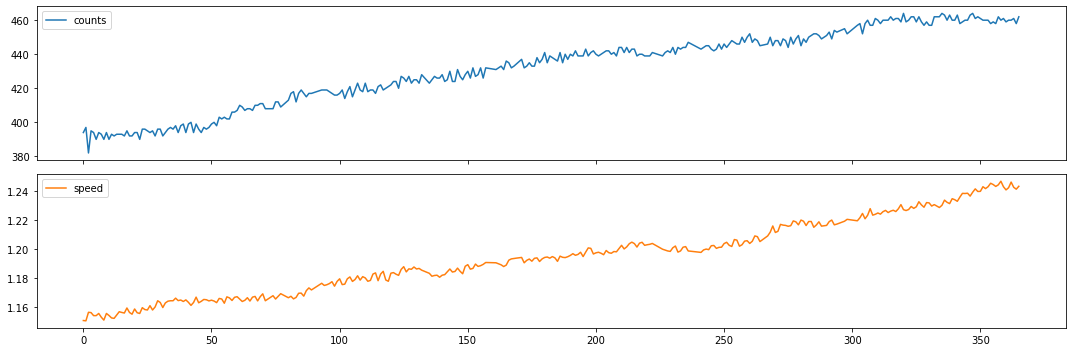

In [29]:
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()
fig,ax = plt.subplots(2, figsize=(15,5), sharex=True)
data_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

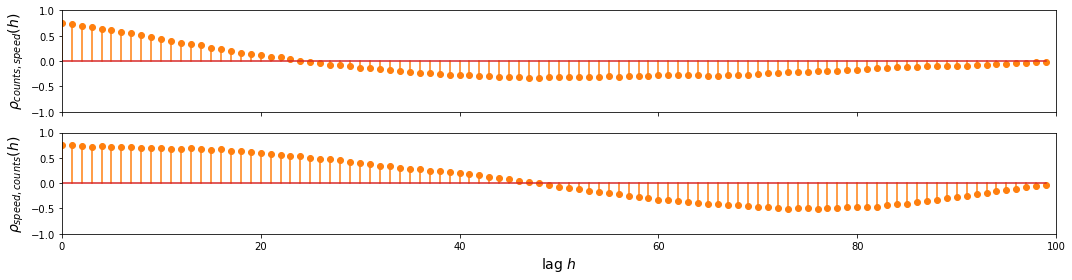

In [30]:
sample_df = data_df.iloc[-100:]
ccf_y1_y2 = ccf(sample_df['counts'], sample_df['speed'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['speed'], sample_df['counts'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{counts,speed} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{speed,counts} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

In [31]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in ['counts', 'speed']: 
    adf_res = adfuller(data_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct},
                          index=['counts', 'speed']).T
adf_res_df.round(4)

,counts,speed
Test statistic,-1.6622,0.5256
p-value,0.4507,0.9856
Critical value - 1%,-3.4487,-3.4485
Critical value - 5%,-2.8696,-2.8695
Critical value - 10%,-2.5711,-2.5710


In [32]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in ['counts', 'speed']: 
    adf_res = adfuller(data_df[c].diff().dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct},
                          index=['counts', 'speed']).T
adf_res_df.round(4)

,counts,speed
Test statistic,-9.7091,-30.1698
p-value,0.0000,0.0000
Critical value - 1%,-3.4487,-3.4485
Critical value - 5%,-2.8696,-2.8695
Critical value - 10%,-2.5711,-2.5710


In [73]:
forecast_length = 92
train_df, test_df = data_df.iloc[:-forecast_length], data_df.iloc[-forecast_length:]
test_df = test_df.filter(test_df.columns[~test_df.columns.str.contains('-d')])

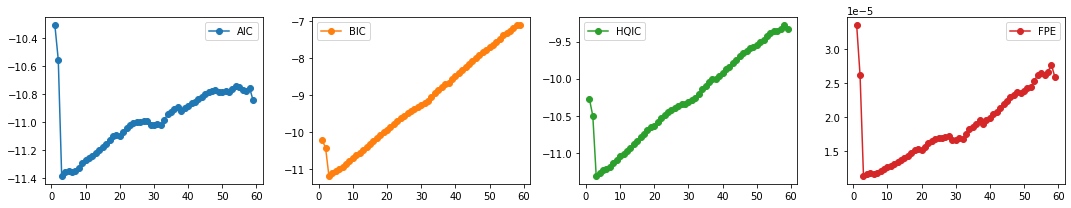

In [74]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df) 
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

In [75]:
%%time
var_model = model.fit(maxlags=3, trend='ct')

CPU times: user 1.32 ms, sys: 0 ns, total: 1.32 ms
Wall time: 1.33 ms


In [76]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jun, 2022
Time:                     10:11:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.1766
Nobs:                     271.000    HQIC:                  -11.3039
Log likelihood:           790.181    FPE:                1.13166e-05
AIC:                     -11.3893    Det(Omega_mle):     1.06770e-05
--------------------------------------------------------------------
Results for equation counts
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            43.870138        53.278747            0.823           0.410
trend             0.015238         0.011037            1.381           0.167
L1.counts         0.204927         0.050490            4.059           0.00

In [77]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],6) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [78]:
granger_causation_matrix(train_df, train_df.columns, 3)  

,counts_x,speed_x
counts_y,1.000000,0.000000
speed_y,0.000904,0.999999


In [90]:
# forecast_var['counts-var'] = np.rint(var_model.forecast(train_df.values, 
#                                       steps=forecast_length, 
#                                       columns=['counts'], 
#                                       index=test_df.index))   

# forecast_var['counts-var'] = var_model.forecast(train_df.values, 
#                                       steps=forecast_length, 
#                                       columns=['speed'], 
#                                       index=test_df.index)

forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})
forecast_var['counts-VAR'] = np.rint(forecast_var['counts-VAR'])

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('RMSE ', round(mean_squared_error(test_df['counts'], forecast_var['counts-VAR'])**0.5,6))
print('MAE ', round(mean_absolute_error(test_df['counts'], forecast_var['counts-VAR']),6))
print('MAPE ', round(mean_absolute_percentage_error(test_df['counts'], forecast_var['counts-VAR']),6))

RMSE  3.800168
MAE  2.902174
MAPE  0.006333


In [93]:
print('RMSE ', round(mean_squared_error(test_df['speed'], forecast_var['speed-VAR'])**0.5,6))
print('MAE ', round(mean_absolute_error(test_df['speed'], forecast_var['speed-VAR']),6))
print('MAPE ', round(mean_absolute_percentage_error(test_df['speed'], forecast_var['speed-VAR']),6))

RMSE  0.008569
MAE  0.007102
MAPE  0.005751


## Compare to ARIMA

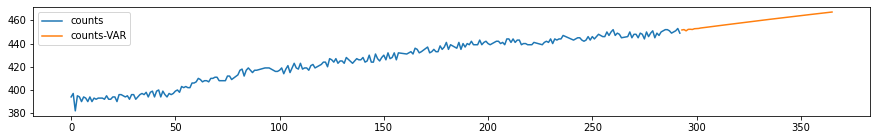

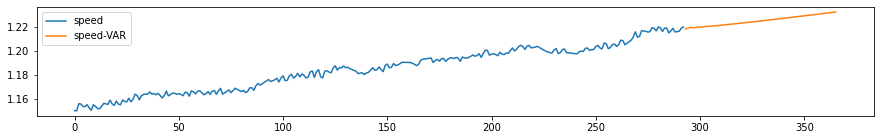

In [46]:
for c in train_df.columns:
    fig, ax = plt.subplots(figsize=[15, 2])
    pd.concat([train_df[[c]], forecast_var[[c+'-VAR']]], axis=1).plot(ax=ax)
    # plt.xlim(left=pd.to_datetime('2005-03-01'))
    plt.xlabel('')
#     plt.tight_layout()
    plt.show()

In [52]:
selected_order = {'counts': [(2, 1, 0)],
                  'speed': [(2, 1, 0)]}

In [58]:
# %%time
forecast_arima = {}
# for c in cols:
#     forecast_arima[c+'-ARIMA'] = utils.forecast_arima(train_df[c].values, 
#                                                       test_df[c].values, 
#                                                       order=selected_order[c][0])

forecast_arima['counts-ARIMA'] = np.rint(utils.forecast_arima(train_df['counts'].values, 
                                                  test_df['counts'].values, 
                                                  order=selected_order['counts'][0]))    

forecast_arima['speed-ARIMA'] = utils.forecast_arima(train_df['speed'].values, 
                                                  test_df['speed'].values, 
                                                  order=selected_order['speed'][0])  

forecast_arima = pd.DataFrame(forecast_arima, index=forecast_var.index)


In [60]:
forecast_arima.tail()

,counts-ARIMA,speed-ARIMA
361,465.0,1.234850
362,465.0,1.235079
363,465.0,1.235308
364,466.0,1.235537
365,466.0,1.235766


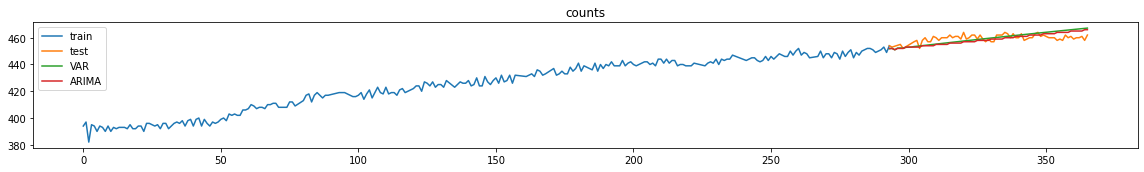

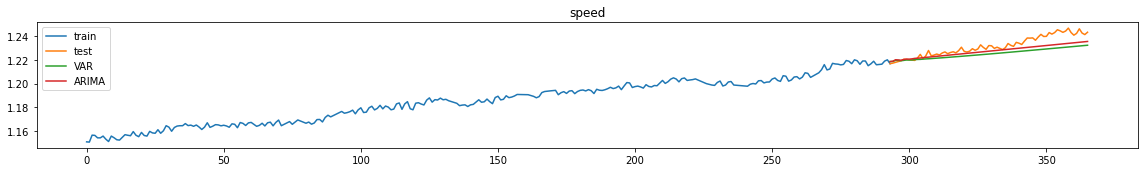

In [61]:
forecasts = pd.concat([forecast_arima, forecast_var], axis=1)
cols
for c in cols:
    fig, ax = utils.plot_forecasts_static(train_df=train_df,
                                          test_df=test_df, 
                                          forecast_df=forecasts, 
                                          column_name=c,
                                          suffix=['-VAR', '-ARIMA'],
                                          title=c)

In [ ]:
pd.concat([utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR'),
           utils.test_performance_metrics(test_df, forecast_arima, suffix='-ARIMA')], axis=1)

,step_counts-VAR,velocity-VAR,step_counts-ARIMA,velocity-ARIMA
MAE,6.040445,0.005593,4.624093,0.003503
MSE,52.315649,0.000051,30.667991,0.000022
MAPE,1.353641,0.973553,1.037817,0.610655
